<a href="https://colab.research.google.com/github/anirban6908/All-active-Manuscript/blob/master/notebooks/Classification/Random_Forest_Classification.ipynb">
   <img align="left" 
      src="https://colab.research.google.com/assets/colab-badge.svg">
</a>
<a href="https://mybinder.org/v2/gh/anirban6908/All-active-Manuscript/blob/master/notebooks/Classification/Random_Forest_Classification.ipynb/master">
   <img align="left" 
      src="https://mybinder.org/badge_logo.svg">
</a>
<a href="https://nbviewer.jupyter.org/github/anirban6908/All-active-Manuscript/blob/master/notebooks/Classification/Random_Forest_Classification.ipynb">
   <img align="right" 
      src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.png" 
      width="109" height="20">
</a>

## Random Forest classification (Figure 4)


In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ateamopt.utils import utility
import man_opt.utils as man_utils
import os
import numpy as np
import matplotlib as mpl
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix,accuracy_score  
from sklearn.model_selection import GridSearchCV,train_test_split  
from sklearn.utils.multiclass import unique_labels
from matplotlib import patches
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import warnings
warnings.filterwarnings('ignore')

### Random Forest Classifier with hyperparameter tuning (# of decision trees, max leaf nodes)

In [2]:
def RF_classifier(X_df,y_df,feature_fields,target_field):
    np.random.seed(0)
    clf = RandomForestClassifier(random_state=0)
    
    le = preprocessing.LabelEncoder()   
    y_df['label_encoder']= le.fit_transform(y_df[target_field])
    
    X_data = X_df.loc[:,feature_fields].values
    y_data = y_df['label_encoder'].values

    X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=0.3, stratify=y_data, random_state=0)
    
    
    ## Hyperparameter selection
    n_tune_split = 3
    
    ## Grid Search
    param_grid = {'n_estimators':np.arange(25,550,25),'max_leaf_nodes':np.arange(2,42,2)}
    tuned_clf = GridSearchCV(clf, param_grid,cv=n_tune_split,n_jobs=6).fit(X_train, y_train)
    
    tuned_max_trees, tuned_max_leaf_nodes = (tuned_clf.best_params_['n_estimators'],
                                    tuned_clf.best_params_['max_leaf_nodes'])

    print('Tuned hyperparameters : n_estimators = %s, max_leaf_nodes = %s\n'%(tuned_max_trees, 
                                  tuned_max_leaf_nodes))
    
    y_pred_test = tuned_clf.predict(X_test)
    y_pred_chance = np.random.choice(y_test,len(y_test))
    confusion_matrix_rf= confusion_matrix(y_test, y_pred_test)
    
    score = accuracy_score(y_test, y_pred_test)
    chance_score = accuracy_score(y_test, y_pred_chance)
    
    classes = le.inverse_transform(unique_labels(y_test, \
                                    y_pred_test))
    
    df_conf_rf = pd.DataFrame(confusion_matrix_rf, classes,classes)
    df_conf_rf =df_conf_rf.div(df_conf_rf.sum(axis=1),axis=0) # Fraction of the actual no.s
    
    df_conf_rf *= 100
    delta_chance = score - chance_score  
    score = np.round(100*score,1)
    delta_chance = np.round(delta_chance*100,1)
    
    test_y_pred,test_y = le.inverse_transform(y_pred_test),\
                                le.inverse_transform(y_test)
    
    feature_imp = pd.Series(tuned_clf.best_estimator_.feature_importances_,
                    index=feature_fields).sort_values(ascending=False)
    feature_fields_sorted = feature_imp.index.values
    feature_dict = {'importance': [], 'param_name' : []}
    for tree in tuned_clf.best_estimator_.estimators_:
        for i, param_name_ in enumerate(feature_fields_sorted):
            sorted_idx = np.where(np.array(feature_fields) == param_name_)[0][0]
            feature_dict['importance'].append(tree.feature_importances_[sorted_idx])
            feature_dict['param_name'].append(param_name_)
    feature_imp_df = pd.DataFrame(feature_dict)
     
    param_group_dict = feature_imp_df.groupby('param_name')['importance'].\
            agg(np.median).to_dict()
    params_sorted =  sorted(param_group_dict, key=param_group_dict.get,
                            reverse=True)
    return score,df_conf_rf,delta_chance,test_y,test_y_pred,feature_imp_df,params_sorted

### Data paths for the all-active models

In [3]:
data_path = os.path.join(os.getcwd(),os.pardir,os.pardir,'assets','aggregated_data')
mouse_data_filename = os.path.join(data_path,'Mouse_class_data.csv')
mouse_datatype_filename = os.path.join(data_path,'Mouse_class_datatype.csv')

param_data_filename = os.path.join(data_path,'allactive_params.csv')
param_datatype_filename = os.path.join(data_path,'allactive_params_datatype.csv')

me_cluster_data_filename = os.path.join(data_path,'tsne_mouse.csv')
cre_coloring_filename = os.path.join(data_path,'rnaseq_sorted_cre.pkl')

### Read the data

In [4]:
mouse_data_df = man_utils.read_csv_with_dtype(mouse_data_filename,mouse_datatype_filename)
hof_param_data = man_utils.read_csv_with_dtype(param_data_filename,param_datatype_filename)
me_cluster_data = pd.read_csv(me_cluster_data_filename,index_col=None)
me_cluster_data.rename(columns={'specimen_id':'Cell_id'},inplace=True)
me_cluster_data['Cell_id'] = me_cluster_data['Cell_id'].astype(str)

param_data = hof_param_data.loc[hof_param_data.hof_index == 0,]
param_data = param_data.drop(labels='hof_index',axis=1)
ephys_cluster = me_cluster_data.loc[:,['Cell_id','ephys_cluster']]
me_cluster = me_cluster_data.loc[:,['Cell_id','me_type']]
cre_cluster = mouse_data_df.loc[mouse_data_df.hof_index==0,['Cell_id','Cre_line']]
bcre_cluster = mouse_data_df.loc[mouse_data_df.hof_index==0,['Cell_id','Broad_Cre_line']]

cre_color_dict = utility.load_pickle(cre_coloring_filename)
rna_seq_crelines = list(cre_color_dict.keys())
all_crelines = cre_cluster.Cre_line.unique().tolist()
cre_pal_all = {cre_:(mpl.colors.to_hex(cre_color_dict[cre_]) 
        if cre_ in rna_seq_crelines else 
             mpl.colors.to_hex('k')) for cre_ in all_crelines}

### Classifier grid

In [5]:
target_field_list = ['ephys_cluster','me_type','Broad_Cre_line','Cre_line']
target_name_list = ['E-type','ME-type','Broad Cre-line','Cre-line']
pass_param_list= ['cm','e_pas', 'Ra','g_pas','gbar_Ih']

p_fields = list(param_data)
other_param_list = [p_field_ for p_field_ in p_fields 
                if p_field_ != 'Cell_id' and not p_field_.startswith(tuple(pass_param_list))]
feature_field_list  = [p_fields,p_fields]
feature_name_list = ['Passive+Ih','All parameters']
feature_data_list = [param_data,param_data]
cluster_data_list = [ephys_cluster,me_cluster,bcre_cluster,cre_cluster]

imp_df_list = []
rf_scores_arr = np.zeros((len(feature_field_list),len(target_field_list)))
rf_conf_mat_grid = {}
test_pred_record = {}
rf_imp_dict,rf_sorted_params = {},{}
delta_chance_arr = np.zeros_like(rf_scores_arr)
least_pop_index = 6

for jj,target_ in enumerate(target_field_list):
    for ii,feature_ in enumerate(feature_field_list):
        
        if ii == 1:
            feature_fields = [feature_field_ for feature_field_ in feature_ \
                  if feature_field_ != 'Cell_id']
        else: # Only training on passive + Ih
            feature_fields = [feature_field_ for feature_field_ in feature_ \
                  if feature_field_ not in ['Cell_id']+other_param_list]
        
        feature_data = feature_data_list[ii]
        cluster_data = cluster_data_list[jj]
        df_clf = pd.merge(feature_data,cluster_data,how='left',
                        on='Cell_id')
        
        if target_ == 'Cre_line':
            df_clf = df_clf.loc[df_clf[target_].isin(rna_seq_crelines),]
            
        X_df,y_df,revised_features = man_utils.prepare_data_clf(df_clf,feature_fields,target_,
            least_pop=least_pop_index)
        
        print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
        print('Classifier Features : %s'%feature_name_list[ii])
        print('Classifier Target : %s'%target_)
        
        
        score,conf_df,delta_chance,test_y,test_y_pred,df_imp,sorted_param_imp= \
                 RF_classifier(X_df,y_df,revised_features,target_)
                 
        df_imp['Features'] = feature_name_list[ii]
        
        if target_ == 'Broad_Cre_line':
            bcre_index_order = ['Htr3a','Sst','Pvalb','Pyr']
            conf_df = conf_df.reindex(index=bcre_index_order,columns=bcre_index_order)
            df_imp['Classifier_target'] = 'Broad Cre-line'
        elif target_ == 'Cre_line':
            cre_indices = conf_df.index
            sorted_cre_indices = [cre_ind_ for cre_ind_ in rna_seq_crelines \
                                  if cre_ind_ in cre_indices]
            conf_df = conf_df.reindex(index=sorted_cre_indices,columns=
                                      sorted_cre_indices)
            cre_indices = [cre.split('-')[0] for cre in sorted_cre_indices]
            conf_df=pd.DataFrame(conf_df.values,index=cre_indices,columns=cre_indices)
            df_imp['Classifier_target'] = 'Cre-line'
        elif target_ == 'ephys_cluster':
            df_imp['Classifier_target'] = 'E-type'
        elif target_ == 'me_type':
            df_imp['Classifier_target'] = 'ME-type'
         
        print('Classifier Accuracy : %s'%score)
        rf_scores_arr[ii,jj] = score
        rf_conf_mat_grid[ii,jj] = conf_df
        delta_chance_arr[ii,jj] = delta_chance    
        rf_imp_dict[ii,jj] = df_imp
        rf_sorted_params[ii,jj] = rf_sorted_params
        test_pred_record[ii,jj] = pd.DataFrame({'true':test_y,'predicted':test_y_pred})

        imp_df_list.append(df_imp)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Passive+Ih
Classifier Target : ephys_cluster
Tuned hyperparameters : n_estimators = 25, max_leaf_nodes = 28

Classifier Accuracy : 51.6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : All parameters
Classifier Target : ephys_cluster
Tuned hyperparameters : n_estimators = 125, max_leaf_nodes = 24

Classifier Accuracy : 56.5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Passive+Ih
Classifier Target : me_type
Tuned hyperparameters : n_estimators = 500, max_leaf_nodes = 8

Classifier Accuracy : 42.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : All parameters
Classifier Target : me_type
Tuned hyperparameters : n_estimators = 100, max_leaf_nodes = 12

Classifier Accuracy : 42.9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Classifier Features : Passive+Ih
Classifier Target : Broad_Cre_line
Tuned hyperparameters : n_estimators = 25, max_leaf_nodes = 18

Classifier Accuracy : 59.3
%%%%%%

### Plotting functions

In [6]:
bpopt_section_names = list(utility.bpopt_section_map.values())
title_fontsize =13
axis_fontsize = 12
tick_fontsize = 12

def plot_classifier_grid(scores_arr,conf_mat_grid,feature_name_list,target_name_list,figname):
    fig_dim_x = scores_arr.shape[0]
    fig_dim_y = scores_arr.shape[1]
    
    sns.set(style="whitegrid")
#    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    cmap = sns.cubehelix_palette(as_cmap=True)

    fig,axes=plt.subplots(fig_dim_x,fig_dim_y,figsize =(16,7),sharex=False,
                          sharey=False,squeeze=False)
    for ii in range(fig_dim_x):
        for jj in range(fig_dim_y):
            
            axes[ii,jj] = sns.heatmap(conf_mat_grid[ii,jj],cmap=cmap,
                    vmin=0,vmax=100,cbar=False,linecolor='k',ax=axes[ii,jj])
            xticklabels = axes[ii,jj].get_xticklabels()
            
            plt.setp(axes[ii,jj].get_yticklabels(),rotation=0,va='center',
                     fontsize=tick_fontsize)
            if ii == 0:
                target_title = target_name_list[jj] + '\n' + '\n'
            else:
                target_title = ''
            if target_name_list[jj] == 'Broad Cre-line':
                xticktext = xticklabels
            else:
                xticktext = [tick.get_text() if ii%2 == 0 else '' for ii,tick in \
                         enumerate(xticklabels)]
            axes[ii,jj].set_xticklabels(xticktext,rotation=60,ha='center',
                     fontsize=tick_fontsize)
            feature_title = feature_name_list[ii]
            if jj == 0:
                axes[ii,jj].set_ylabel('True Label',labelpad=15,fontsize=axis_fontsize)
            elif jj == fig_dim_y-1:
                axes[ii,jj].set_ylabel(feature_title,labelpad=10,fontsize=axis_fontsize)
                axes[ii,jj].yaxis.set_label_position("right")
            prefix_title = 'Acc. : {}% '.format(scores_arr[ii,jj])
            percent_text = r'$(\Uparrow{}\%)$'.format(delta_chance_arr[ii,jj])
            axes[ii,jj].set_title(target_title+prefix_title+percent_text,fontsize=title_fontsize)
    
    fig.text(0.5, -0.05, 'Predicted Label', ha='center',fontsize=axis_fontsize)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    sm._A = []
    cax = fig.add_axes([0.7, -0.05, 0.2, .03])
    cbar = fig.colorbar(sm,orientation='horizontal',cax=cax)
    cbar.ax.set_xlabel('%-age of row',fontsize=tick_fontsize)
    cbar.outline.set_visible(False)

    fig.subplots_adjust(wspace=.6,hspace=.65)
    fig.savefig(figname,dpi=80,bbox_inches='tight')
    plt.show()

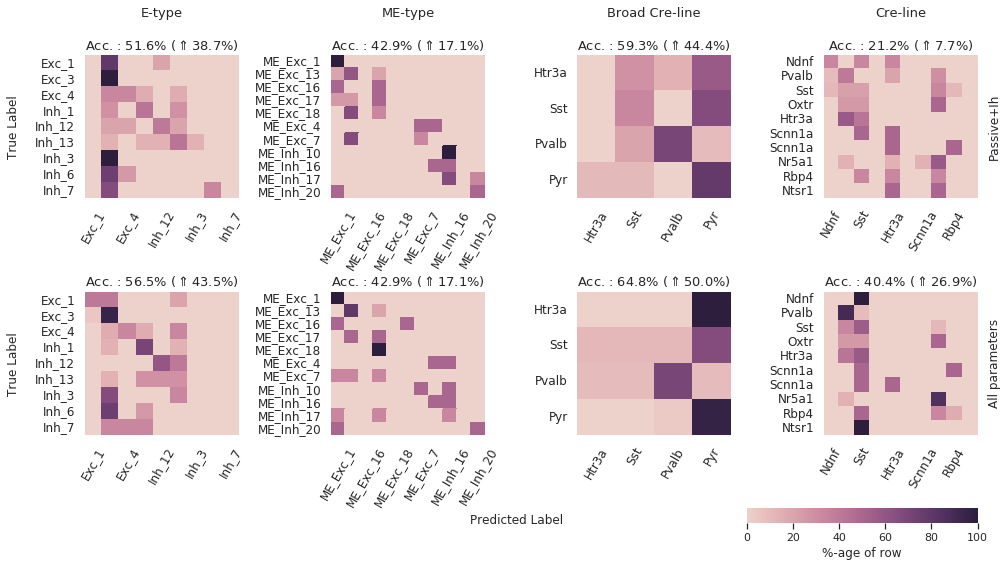

In [7]:
plot_classifier_grid(rf_scores_arr,rf_conf_mat_grid,feature_name_list,
                     target_name_list,figname='figures/RF_Classifier_grid.pdf')

### Feature importance

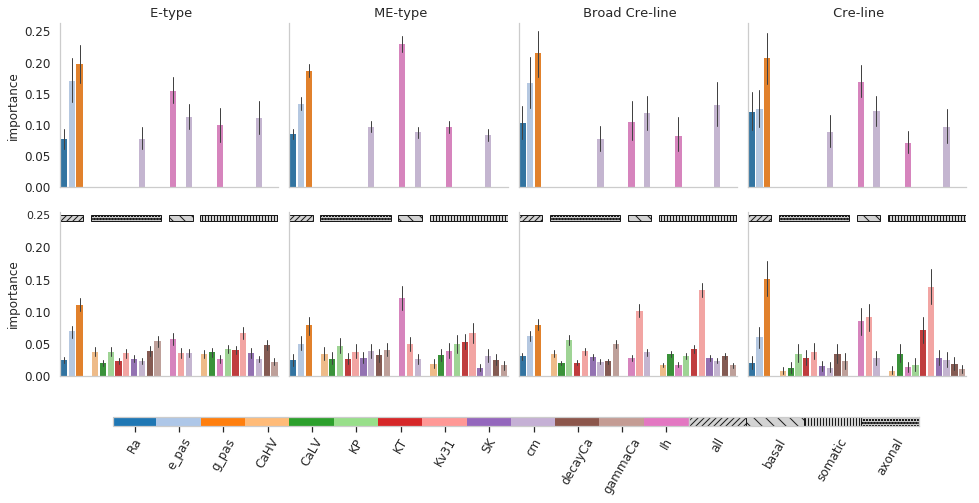

In [8]:
def unique_list(sequence):
    ''' 
    Get unique elements from the list with order preserved
    '''
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]


feature_imp_df = pd.concat(imp_df_list,sort=False,ignore_index=True)       
    
# Add a fake row to the dataframe to create separation in the figure
phantom_df = pd.DataFrame({'param_name':['cm.asphantom','cm.azphantom',\
                         'cm.bzphantom'],
                        'Features' : ['All parameters']*3,
                        'Classifier_target':['Cre-line']*3,
                        'importance': [0]*3})

feature_imp_df = pd.concat([feature_imp_df,phantom_df],sort=False,
                           ignore_index=True)

sorted_param_names = []
for ii,param_ in enumerate(feature_imp_df.param_name):
    param_split = param_.split('.')
    param_name_ = param_split[0]
    param_name_ = man_utils.replace_channel_name(param_name_)
    feature_imp_df.at[ii,'param_name'] = param_split[-1] + '.'+param_name_
    sorted_param_names.append(param_split[-1] + '.'+param_name_)
    
    sorted_param_names = sorted(list(set(sorted_param_names)))
    unique_section_names = list(set([param.split('.')[0] for param \
                     in sorted_param_names if param.split('.')[0] in \
                     bpopt_section_names]))
all_section_names = [param.split('.')[0] for param in sorted_param_names]
section_st_end_ticks = {}

for sect in unique_section_names:
    section_st_end_ticks[sect]= [all_section_names.index(sect)-.5,\
                len(all_section_names)-list(reversed(all_section_names)).\
                index(sect)-1 +.5]


channel_names = unique_list([sorted_param.split('.')[-1] for sorted_param in 
                          sorted_param_names if sorted_param.split('.')[0] in 
                        bpopt_section_names])

ticklabels = ['']*len(sorted_param_names)
    
colors = sns.color_palette('tab20',len(channel_names))
colors_dict = {channel:color for channel,color in zip(channel_names,colors)}
hatch_dict = {sect:hatch_ for sect,hatch_ in zip(unique_section_names,
                                            ['////','\\\\', '||||','oooo'])}

my_cmap = ListedColormap(colors)
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,len(channel_names)-1))
sm.set_array([])
 
ymax = max(list(feature_imp_df.groupby(['param_name','Features','Classifier_target'])['importance'].\
            agg(np.median).to_dict().values())) +.01

facetgrid_colors= [colors_dict[param_.split('.')[-1]] if param_.split('.')[0] in \
                   bpopt_section_names else 'k' \
                               for param_ in sorted_param_names]    
g = sns.FacetGrid(feature_imp_df,col='Classifier_target',row='Features',
              sharex=True,sharey='row')
g = g.map(sns.barplot,'param_name','importance',
          order=sorted_param_names,palette=facetgrid_colors,errwidth=1,
          linewidth=0)  

for ii,ax in enumerate(g.axes.ravel()):
    ax.set_xticklabels(ticklabels,rotation=90,ha='center',
             fontsize=tick_fontsize)
    plt.setp(ax.get_yticklabels(),fontsize=tick_fontsize)
    
    title = ax.get_title()
    if ii < len(target_field_list):
        title_ = title.split('=')[-1]
        ax.set_title(title_,fontsize=title_fontsize)
    else:
        ax.set_title('')
        for sect in unique_section_names:
            x1,x2 =section_st_end_ticks[sect][0],section_st_end_ticks[sect][1]
            ax.add_patch(patches.Rectangle((x1, ymax),(x2-x1),0.01,
                               facecolor='lightgrey',hatch=hatch_dict[sect],
                                            edgecolor='k'))
        ax.set_ylim([0,ymax+0.015])
    ax.set_xlabel('')
    ax.grid(False)
    if ax.get_ylabel() != '':
        ax.set_ylabel(ax.get_ylabel(),fontsize=axis_fontsize)
    
fig = g.fig
fig.set_size_inches(16,6)
fig.subplots_adjust(wspace=0.05,hspace = 0.15)
cax = fig.add_axes([0.15, 0.0, 0.5, .02])
patch_ax = fig.add_axes([0.65, 0.0, 0.2, .02])
patch_origin = 0
patch_tickmarks,patch_ticklabels= [],[]
for hatch_key,hatch_val in hatch_dict.items():
    patch_ax.add_patch(patches.Rectangle((patch_origin, 0),.25,1,
                               facecolor='lightgrey',hatch=hatch_val,
                                            edgecolor='k'))
    
    patch_tickmarks.append(patch_origin+.25/2)
    patch_ticklabels.append(hatch_key)
    patch_origin += .25


patch_ax.set_yticklabels(['']*len(patch_ax.get_yticklabels()))
patch_ax.set_xticks(patch_tickmarks)
patch_ax.set_xticklabels(patch_ticklabels,rotation=60,ha='center',
                         fontsize=axis_fontsize)

cbar = fig.colorbar(sm,boundaries=np.arange(len(channel_names)+1)-0.5,
                    orientation='horizontal',cax=cax)
cbar.set_ticks(np.arange(len(channel_names)))
cbar.ax.set_xticklabels(channel_names, fontsize=axis_fontsize,rotation=60)    
    

fig.savefig('figures/RF_param_importance_grid.pdf',bbox_inches='tight') 
plt.show()     
